In [23]:

import sys
from pathlib import Path
from datetime import timedelta
import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr
from contextlib2 import redirect_stdout
import random
import usad
from ipywidgets import FloatProgress

## 파라미터 세팅

In [24]:

# 파라미터 세팅
DATANAME = 'SWaT'
Filenum = "USAD,HAI_"
N_HIDDENS1 = 200 # 
N_LAYERS1 = 3 # 
BATCH_SIZE = 2048

EPOCH = 30 #
WINDOW_GIVEN = 11
WINDOW_SIZE = WINDOW_GIVEN + 1



In [25]:
# Feature Test 중 Seed 고정을 위해 사용하였음.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [26]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [27]:

def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [28]:
# 학습과정에서 Optimizer는 Baseline코드와 동일하며, L1Loss(MAE)로 변경하여 사용함
# 데이터 shuffle은 유지하였음

def train(dataset, model, batch_size, n_epochs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.L1Loss()
    epochs = trange(n_epochs, desc="training")
    best = {"loss": sys.float_info.max}
    loss_history = []

    for e in epochs:
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            given = batch["given"].cuda()
            guess = model(given)
            answer = batch["answer"].cuda()
            loss = loss_fn(answer, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history

In [29]:
class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE):
            self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False
    def __len__(self):
        return self.n_idxs
    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        given = self.tag_values[i]
        item["given"] = torch.from_numpy(given)
        item["answer"] = torch.from_numpy(given[WINDOW_GIVEN])
        return item

In [30]:
class HaiDataset2(Dataset):
    def __init__(self, df, stride=1, attacks=None):
        self.tag_values = np.array(df)
        self.valid_idxs = []
        for L in trange(df.shape[0] - WINDOW_SIZE + 1):
            self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False
    def __len__(self):
        return self.n_idxs
    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        return item

In [31]:
# Relu함수를 쓰기 위해 코드 추가하였음 "------------------- Check " << 부분
class StackedGRU(torch.nn.Module):
    def __init__(self, n_tags):
        super().__init__()
        self.rnn = torch.nn.GRU(
            input_size=n_tags,
            hidden_size=N_HIDDENS1,
            num_layers=N_LAYERS1,
            bidirectional=True,
            dropout=0,
        )
        self.fc = torch.nn.Linear(N_HIDDENS1 * 2, n_tags)
        self.relu = torch.nn.ReLU()# ------------------- Check 

    def forward(self, x):
        x = x.transpose(0, 1)  # (batch, seq, params) -> (seq, batch, params)
        self.rnn.flatten_parameters()
        outs, _ = self.rnn(x)
        out = self.fc(self.relu(outs[-1]))# ------------------- Check 
        return  x[0]+out

In [32]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [33]:
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [34]:

def inference_basic(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy())
            #dist.append(guess.cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))

    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

In [35]:
def inference_residual(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    dist, att = [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given)
            dist.append(torch.abs(answer - guess).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))

    return (
        np.concatenate(dist),
        np.concatenate(att),
    )

In [36]:
# Switch 파라미터를 통해서 검증그래프와 테스트그래프를 저장함
def check_graph(xs, att, piece=2, THRESHOLD=None, Switch=1):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        axs[i].set_ylim(0, 0.2)
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    if Switch == 1:
        plt.savefig("usad_hai/"+ str(Filenum) + '_' + str(WINDOW_GIVEN) + '_' + str(N_HIDDENS1) + '_' + str(N_LAYERS1) + '_' + str(BATCH_SIZE) + '_' + str(THRESHOLD) + '_' + 'evaluation.png')
    elif Switch == 2:
        plt.savefig("usad_hai/" + str(Filenum) + '_' + str(WINDOW_GIVEN) + '_' + str(N_HIDDENS1) + '_' + str(N_LAYERS1) + '_' + str(BATCH_SIZE) + '_' + str(THRESHOLD) + '_' + 'baseline.png')

In [37]:
# Data Load & Merge function
def data_load_merge (dataname) :
    if dataname == 'HAI' :
        TRAIN_DATASET = sorted([x for x in Path("data/HAI 2.0/training/").glob("*.csv.gz")]) 
        train_data= dataframe_from_csvs(TRAIN_DATASET)

        VALIDATION_DATASET = sorted([x for x in Path("data/HAI 2.0/validation/").glob("*.csv.gz")])
        validation_data = dataframe_from_csvs(VALIDATION_DATASET)

    elif dataname == 'SWaT' :
        train_data = pd.read_csv("data/SWaT_Dataset_Normal_v1.csv")
        validation_data = pd.read_csv("data/SWaT_Dataset_Attack_v0.csv",sep=";")

    elif dataname == 'WADI': 
        train_data = pd.read_csv("data/WADI_14days_new.csv")
        length = int(train_data.shape[0]*0.8)
        train_data = train_data.iloc[:length]
        validation_data = pd.read_csv("data/WADI_attackdataLABLE.csv", header=1)

    return train_data, validation_data

In [38]:
TRAIN_DF_RAW, VALIDATION_DF_RAW = data_load_merge(DATANAME) 

In [39]:
# HAI data preprocessing
if DATANAME == 'HAI' :
    columns = TRAIN_DF_RAW.columns
    TIMESTAMP_FIELD = "time"
    ATTACK_FIELD = "attack"

# SWaT data preprocessing
if DATANAME == 'SWaT' :
    TRAIN_DF_RAW.loc[TRAIN_DF_RAW['Normal/Attack']=='Normal','Normal/Attack']=0
    VALIDATION_DF_RAW.loc[VALIDATION_DF_RAW['Normal/Attack']=='Normal','Normal/Attack']=0
    VALIDATION_DF_RAW.loc[VALIDATION_DF_RAW['Normal/Attack']!=0,'Normal/Attack']=1

    TIMESTAMP_FIELD = "Timestamp"
    ATTACK_FIELD = "attack"
    VALIDATION_DF_RAW["attack"] = VALIDATION_DF_RAW["Normal/Attack"]

 # WADI data preprocessing
if DATANAME == 'WADI' :
    VALIDATION_DF_RAW.loc[VALIDATION_DF_RAW['Attack LABLE (1:No Attack, -1:Attack)']==1,'Attack LABLE (1:No Attack, -1:Attack)']=0
    VALIDATION_DF_RAW.loc[VALIDATION_DF_RAW['Attack LABLE (1:No Attack, -1:Attack)']==-1,'Attack LABLE (1:No Attack, -1:Attack)']=1
    VALIDATION_DF_RAW['attack'] =VALIDATION_DF_RAW['Attack LABLE (1:No Attack, -1:Attack)']
    VALIDATION_DF_RAW = VALIDATION_DF_RAW.drop(columns=['Attack LABLE (1:No Attack, -1:Attack)'])

    TIMESTAMP_FIELD = "Time"
    ATTACK_FIELD = "attack"


In [40]:
# USAD FRONT 모델 결과를 불러옴
TRAIN_RESULT= np.load('usad_hai/usad_swat_train.npy')

In [41]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Traceback (most recent call last):
  File "c:\users\user\anaconda3\envs\anomaly_hai1\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\user\anaconda3\envs\anomaly_hai1\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\user\anaconda3\envs\anomaly_hai1\Scripts\jupyter-nbextension.EXE\__main__.py", line 7, in <module>
  File "c:\users\user\anaconda3\envs\anomaly_hai1\lib\site-packages\jupyter_core\application.py", line 264, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "c:\users\user\anaconda3\envs\anomaly_hai1\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "c:\users\user\anaconda3\envs\anomaly_hai1\lib\site-packages\notebook\nbextensions.py", line 980, in start
    super().start()
  File "c:\users\user\anaconda3\envs\anomaly_hai1\

In [42]:
DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_RESULT, stride=1)

  0%|          | 0/494988 [00:00<?, ?it/s]

# of valid windows: 494988


training:   0%|          | 0/4 [00:00<?, ?it/s]

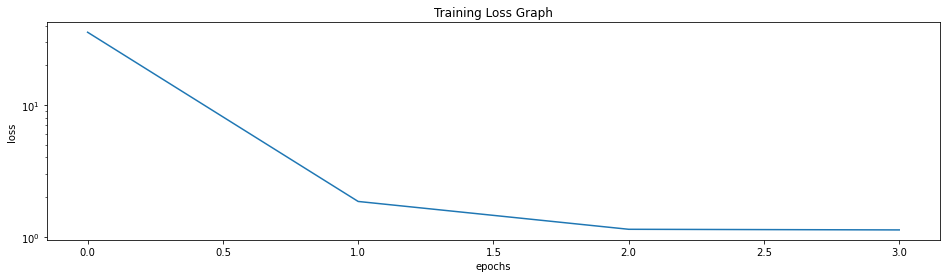

In [43]:
# 모델의 THRESHOLD가 0.04 수준까지 되었을 때(오탐이 없는), 좋은 모델이라 판단하였음

MODEL1 = StackedGRU(n_tags=TRAIN_RESULT.shape[2])
MODEL1.cuda()
Filenum1 = "model1"

# Find Best Model
MODEL1.train()
BEST_MODEL1, LOSS_HISTORY1 = train(DATASET_TRAIN, MODEL1, BATCH_SIZE, EPOCH)
BEST_MODEL1["loss"], BEST_MODEL1["epoch"]

with open("usad_hai/" + str(Filenum1) + '_' + str(WINDOW_GIVEN) + "_" + str(N_HIDDENS1) + "_" + str(N_LAYERS1) + '_' + str(BATCH_SIZE) + "_model.pt", "wb") as f:
    torch.save(
        {
            "state": BEST_MODEL1["state"],
            "best_epoch": BEST_MODEL1["epoch"],
            "loss_history": LOSS_HISTORY1,
        },
        f,
    )
with open("usad_hai/" + str(Filenum1) + '_' + str(WINDOW_GIVEN) + "_" + str(N_HIDDENS1) + "_" + str(N_LAYERS1) + '_' + str(BATCH_SIZE) + "_model.pt", "rb") as f:
    SAVED_MODEL1 = torch.load(f)

torch.cuda.empty_cache()
MODEL1.load_state_dict(SAVED_MODEL1["state"])

plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(SAVED_MODEL1["loss_history"])
plt.savefig("usad_hai/" + str(Filenum1) + '_' + str(WINDOW_GIVEN) + '_' + str(N_HIDDENS1) + '_' + str(N_LAYERS1) + '_' + str(BATCH_SIZE) + "_loss.png")
with open("usad_hai/" + str(Filenum1) + '_' + str(WINDOW_GIVEN) + '_' + str(N_HIDDENS1) + '_' + str(N_LAYERS1) + '_' + str(BATCH_SIZE) + "_loss_history.txt", 'w') as f:
    with redirect_stdout(f):
        print(SAVED_MODEL1["loss_history"])


## Testing

In [44]:
# front USAD model test result 
VALIDATION_RESULT= np.load('usad_hai/usad_swat_test.npy')

In [45]:
print(VALIDATION_RESULT.shape)
print(VALIDATION_DF_RAW[TIMESTAMP_FIELD].shape)
print(VALIDATION_DF_RAW[ATTACK_FIELD].shape)

(449907, 12, 39)
(449919,)
(449919,)


In [46]:
# back GRU model test result 
HAI_DATASET_VALIDATION1 = HaiDataset(VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_RESULT, attacks=VALIDATION_DF_RAW[ATTACK_FIELD])

# Model Load
with open("usad_hai/" + str(Filenum1) + '_' + str(WINDOW_GIVEN) + '_' + str(N_HIDDENS1) + '_' + str(N_LAYERS1) + '_' + str(BATCH_SIZE) + "_model.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

MODEL1 = StackedGRU(n_tags=TRAIN_RESULT.shape[2])
MODEL1.load_state_dict(SAVED_MODEL["state"])
MODEL1.to(torch.device("cuda")) # use GPU 

MODEL1.eval()

#inference 함수는 데이터를 순차적으로 보면서 모델이 예측한 값과 실제 값의 차를 구해서 기록합니다.
CHECK_TS1, CHECK_DIST1, CHECK_ATT1 = inference_basic(HAI_DATASET_VALIDATION1, MODEL1, BATCH_SIZE)

  0%|          | 0/449907 [00:00<?, ?it/s]

# of valid windows: 449907


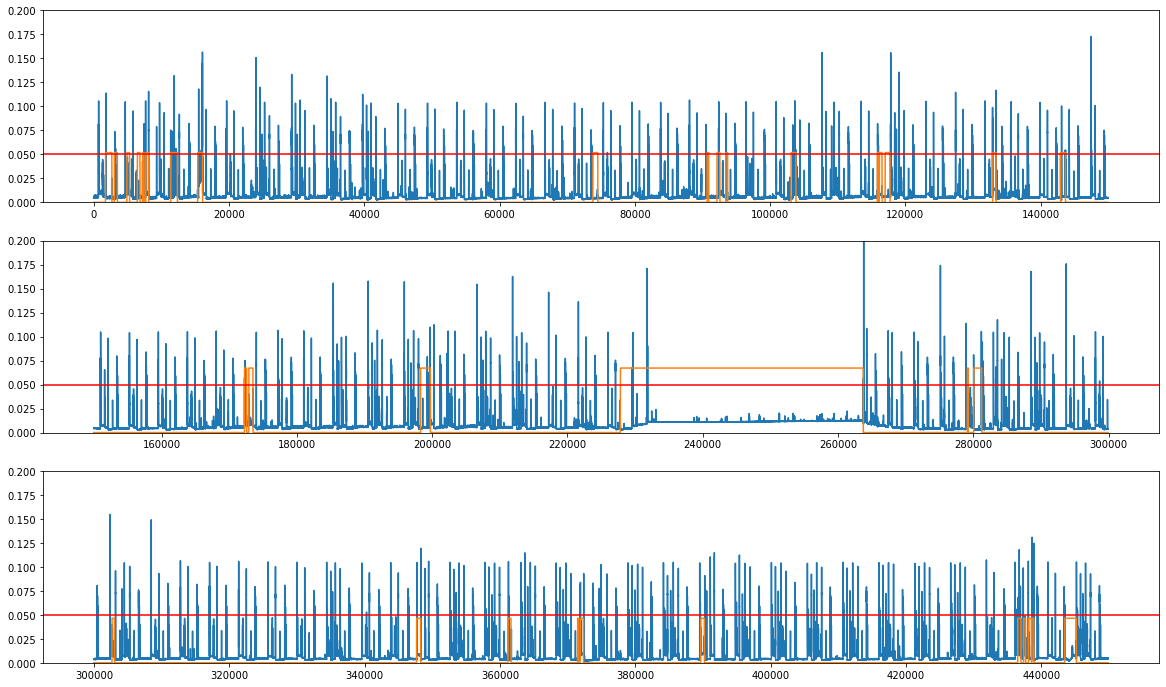

In [47]:
# 모델 체크
THRESHOLD = 0.05
ANOMALY_SCORE = np.mean(CHECK_DIST1, axis=1)
check_graph(ANOMALY_SCORE, CHECK_ATT1, piece=3, THRESHOLD=THRESHOLD, Switch=1)

LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

FINAL_LABELS = fill_blank(CHECK_TS1, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
FINAL_LABELS.shape

ATTACK_LABELS.shape[0] == FINAL_LABELS.shape[0]

# 검증데이터 평가결과 저장
TaPR = etapr.evaluate_w_streams(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
recall = np.round(TaPR['recall'],4)
precision = np.round(TaPR['precision'],4)
f1_score = 2*(TaPR['precision']*TaPR['recall']/(TaPR['precision']+TaPR['recall']))
f1_score = np.round(f1_score,4)
with open("usad_hai/"+ str(Filenum) + '_' + str(WINDOW_GIVEN) + '_' + str(N_HIDDENS1) + '_' + str(N_LAYERS1) + '_' + str(BATCH_SIZE) + '_'+ str(THRESHOLD) + '_evaluation.txt', 'w') as f:
    with redirect_stdout(f):
        print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
        print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
        print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")
        print(f"\n")
        print(f'Point-adjust 점수')
        print(f"recall : {recall}")
        print(f"precision : {precision}")
        print(f"f1_score : {f1_score}")

torch.cuda.empty_cache()



